In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
cd/content/drive/MyDrive/Colab Notebooks/PROJECT

/content/drive/MyDrive/Colab Notebooks/PROJECT


In [ ]:
!git clone https://github.com/duyvuleo/VNTC.git

Cloning into 'VNTC'...
remote: Enumerating objects: 39, done.
remote: Total 39 (delta 0), reused 0 (delta 0), pack-reused 39
Unpacking objects: 100% (39/39), done.
Checking out files: 100% (15/15), done.


In [2]:
!pip install pyvi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.5 MB 17.4 MB/s 
     |████████████████████████████████| 965 kB 45.4 MB/s 


In [3]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from keras.layers import Input, Dense, Reshape, Embedding, Bidirectional, GRU, LSTM, Dropout
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping
from keras.models import Model, load_model
from keras.preprocessing import text, sequence
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from keras import backend as K
from pyvi import ViTokenizer # thư viện NLP tiếng Việt
from tqdm import tqdm
import numpy as np
import gensim # thư viện NLP

In [4]:
import os 

def get_data(folder_path):
    data = []
    labels = []
    dirs = os.listdir(folder_path)
    for path in tqdm(dirs):
        file_paths = os.listdir(os.path.join(folder_path, path))
        for file_path in (file_paths):
            with open(os.path.join(folder_path, path, file_path), 'r', encoding="utf-16") as f:
                lines = f.readlines()
                lines = ' '.join(lines)
                
                #Tien xu li du lieu don gian
                lines = gensim.utils.simple_preprocess(lines)
                lines = ' '.join(lines)
        
                #Tách từ tiếng Việt
                lines = ViTokenizer.tokenize(lines)
                data.append(lines)
                labels.append(path)

    return data, labels

In [ ]:
!unrar x -Y "VNTC/Data/10Topics/Ver1.1/Test_Full.rar" "VNTC/Data/10Topics/Ver1.1"
!unrar x -Y "VNTC/Data/10Topics/Ver1.1/Train_Full.rar" "VNTC/Data/10Topics/Ver1.1"

In [5]:
X_data, y_data = get_data('VNTC/Data/10Topics/Ver1.1/Train')

100%|██████████| 10/10 [23:15<00:00, 139.57s/it]


In [6]:
X_test, y_test = get_data('VNTC/Data/10Topics/Ver1.1/Test')

100%|██████████| 10/10 [13:50<00:00, 83.02s/it]


In [7]:
X_data, X_val, y_data, y_val = train_test_split(X_data, y_data, test_size=0.1, random_state=42, stratify = y_data)

In [8]:
# TRICH XUAT DAC TRUNG 
def preprocess(text, tokenized = True, lowercased = True):
    text = ViTokenizer.tokenize(text) if tokenized else text
    text = text.lower() if lowercased else text
    return text

def pre_process_features(X, y, tokenized = True, lowercased = True):
    X = [preprocess(str(p), tokenized = tokenized, lowercased = lowercased) for p in list(X)]
    for idx, ele in enumerate(X):
        if not ele:
            np.delete(X, idx)
            np.delete(y, idx)
    return X, y
train_X, train_y = pre_process_features(X_data, y_data, tokenized=True, lowercased = True)
val_X, val_y = pre_process_features(X_val, y_val, tokenized=True, lowercased = True)
test_X, test_y = pre_process_features(X_test, y_test, tokenized=True, lowercased = True)

In [9]:
# Độ dài trung bình mỗi câu
sent_lens = [len(sentence.split()) for sentence in train_X]
avg_sent_len = np.mean(sent_lens)
avg_sent_len # trả về độ dài trung bình của câu (tính bằng token)

383.83977059666927

In [10]:
# 95% câu có độ dài là 
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

919

In [11]:
# sử dụng lớp TfidfVectorizer để chuyển đổi các câu  thành số
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(analyzer='word', max_features=10000)

tfidf_X_data =  tfidf_vect.fit_transform(train_X)
tfidf_X_val =  tfidf_vect.transform(val_X)
tfidf_X_test =  tfidf_vect.transform(test_X)

In [12]:
# TruncatedSVD works on tf-idf matrices ==> Phân tích ngữ nghĩa tiềm ẩn
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=1024, random_state=42)
tfidf_X_data_svd = svd.fit_transform(tfidf_X_data)
tfidf_X_val_svd = svd.transform(tfidf_X_val)
tfidf_X_test_svd = svd.transform(tfidf_X_test)

In [13]:
# Trích xuất nhãn và mã hóa chúng thành số nguyên
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_y)
val_labels_encoded = label_encoder.transform(val_y)
test_labels_encoded = label_encoder.transform(test_y)

# Kiểm tra xem nhãn huấn luyện trông như thế nào
train_labels_encoded

array([3, 6, 1, ..., 9, 6, 8])

In [49]:
# Build model
model = keras.Sequential()
model.add(Input(shape=(1024,)))
model.add(Reshape((1, 1024)))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_6 (Reshape)         (None, 1, 1024)           0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 256)              1180672   
 nal)                                                            
                                                                 
 dense_18 (Dense)            (None, 256)               65792     
                                                                 
 dense_19 (Dense)            (None, 64)                16448     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_20 (Dense)            (None, 10)                650       
                                                      

In [50]:
# Optimize và Compile model
def optimize(model):

    model.compile(optimizer=optimizers.Adam(learning_rate=1e-2),
                  loss='sparse_categorical_crossentropy',
                  metrics=['acc'])
    return model

model = optimize(model)

In [51]:
# Tạo callback model
def callback_model(checkpoint_name, logs_name):
    
    #1 Tạo tensorboard callback để lưu logs
    tensorboard_callback = TensorBoard(logs_name, histogram_freq=1)
    #2 Tạo checkpoint callback để lưu checkpoint với độ chính xác tốt nhất sau mỗi epoch.
    checkpoint_callback = ModelCheckpoint(filepath=checkpoint_name,
                                          save_freq='epoch',
                                          monitor='acc',
                                          save_best_only=True,
                                          verbose=1)
    #3 Tạo ReduceLROnPlateau callback với factor=0.3, patience=1 và "Validation F1-score" monitor.
    ReduceLROnPlateau_callback = ReduceLROnPlateau(monitor="val_acc", factor=0.3, patience=1, verbose=1)
    #4 Tạo early stopping callback với patience=5, mode = 'max' và "Validation F1-score" monitor.
    early_stop_callback = EarlyStopping(monitor="val_acc", patience=5, mode="max", verbose=1)
    # 5 Tổng hợp callback list
    callbacks_list = [tensorboard_callback, checkpoint_callback, ReduceLROnPlateau_callback, early_stop_callback]
    return callbacks_list

checkpoint_name = 'weights.best.hdf5'
logs_name = 'training_logs'
callbacks_list = callback_model(checkpoint_name, logs_name)

In [52]:
# Train model
def train_model(model):
    '''
    Input: 
        Mô hình và callback list,
    Return: 
        Mô hình với trọng số checkpoint tốt nhất.
    '''
    model.fit(tfidf_X_data_svd, train_labels_encoded,
              validation_data=(tfidf_X_val_svd, val_labels_encoded),
              epochs=40, batch_size=128,
              verbose=1,
              callbacks=callbacks_list)
    model = load_model(filepath = checkpoint_name)
    return model

model = train_model(model)

Epoch 1/40
348/355 [============================>.] - ETA: 0s - loss: 0.4464 - acc: 0.8615
Epoch 1: acc improved from -inf to 0.86220, saving model to weights.best.hdf5
355/355 [==============================] - 7s 11ms/step - loss: 0.4446 - acc: 0.8622 - val_loss: 0.2893 - val_acc: 0.9145 - lr: 0.0100
Epoch 2/40
355/355 [==============================] - ETA: 0s - loss: 0.2495 - acc: 0.9203
Epoch 2: acc improved from 0.86220 to 0.92026, saving model to weights.best.hdf5

Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0029999999329447745.
355/355 [==============================] - 2s 7ms/step - loss: 0.2495 - acc: 0.9203 - val_loss: 0.2747 - val_acc: 0.9115 - lr: 0.0100
Epoch 3/40
347/355 [============================>.] - ETA: 0s - loss: 0.1498 - acc: 0.9485
Epoch 3: acc improved from 0.92026 to 0.94860, saving model to weights.best.hdf5
355/355 [==============================] - 2s 7ms/step - loss: 0.1494 - acc: 0.9486 - val_loss: 0.2504 - val_acc: 0.9232 - lr: 0.0030
Epoch 4

In [53]:
# Đưa ra dự đoán
prediction = model.predict(tfidf_X_test_svd, batch_size=256, verbose=0)
y_pred = prediction.argmax(axis=-1)

[[4417  180   38  192  176   65   42   13   63   33]
 [  96 2747   94   24   12   58   24   13   72   19]
 [  34   70 1556    8    1   75   38    2   15   21]
 [  89   17   10 2386   10    4   13    1    1   21]
 [ 214   25    3   34 3528    7   11   27    8   11]
 [  87   47   78    7    7 3120   31    2    4    1]
 [  35   37   24   41    9   33 2677    3   26   13]
 [  24   26    2    1    4   10   28 5181   15    7]
 [  62   95   16    1    6    2   16    7 2869    6]
 [  33   15   23   65    4    2   22    2    8 2307]]
F1 - micro: 0.9119938386800557
F1 - macro: 0.9083703250941058
Accuracy: 0.9119938386800557


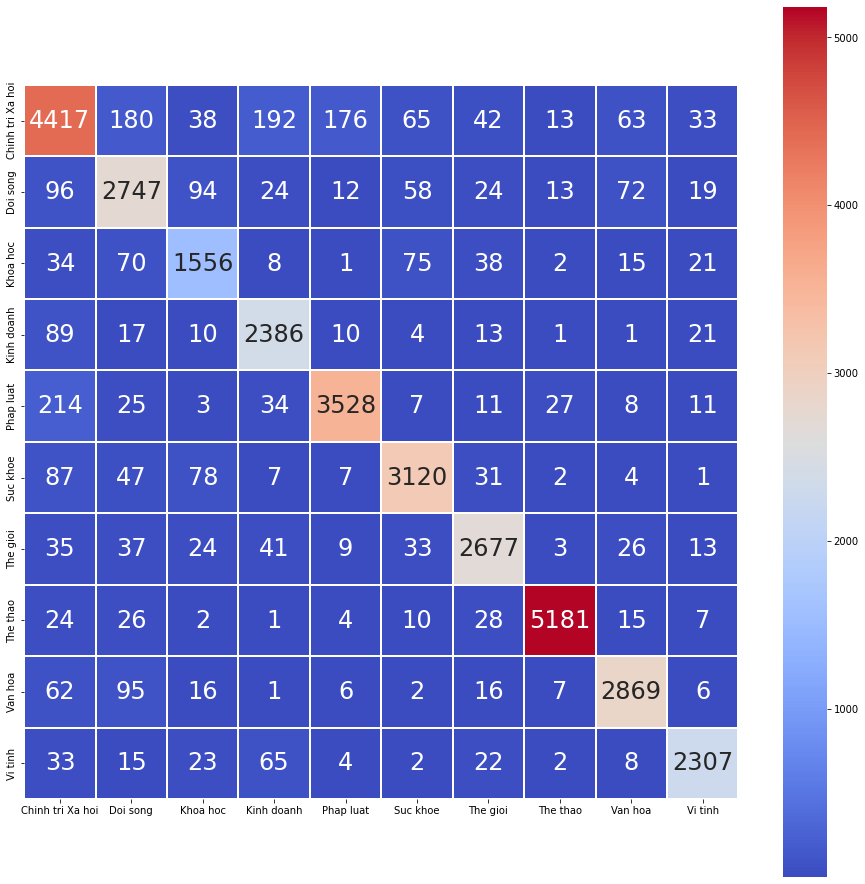

In [54]:
# Tính Confusion matrix
cf = confusion_matrix(test_labels_encoded, y_pred)
print(cf)

# Tính F1 micro
eval_micro = f1_score(test_labels_encoded, y_pred, average='micro')
print("F1 - micro: " + str(eval_micro))

# Tính F1 macro
eval_macro = f1_score(test_labels_encoded, y_pred, average='macro')
print("F1 - macro: " + str(eval_macro))

# Tính Accuracy score
acc_sc = accuracy_score(test_labels_encoded, y_pred)
print("Accuracy: " + str(acc_sc))

# Hiển thị Confusion matrix
df_cm = pd.DataFrame(cf, index = label_encoder.classes_,
        columns = label_encoder.classes_)
plt.subplots(figsize=(16, 16))
sn.heatmap(df_cm, annot=True, cmap="coolwarm",fmt='d', linewidths = 1, cbar=True, square = True, annot_kws={"size": 24})